In [1505]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from tqdm import tqdm

np.random.seed(0)

## Assignment 9: Prediction error methods (PEM)

### Task 1

Implement the system
$$y_k + a y_{k-1} = b u_{k-1} + e_k$$

where
- $e_k$ is white Gaussian zero-mean noise with variance $\lambda^2$.

- the input is computed through a state-feedback law $u_k = - K y_k + r_k$ with $r_k$ a reference signal.

- $K$ is so that the closed loop system in the absence of the reference signal is asymptotically stable, and the mode of the system is non-oscillatory.

- $r_k$, for the sake of this assignment, is another white Gaussian zero-mean noise with variance $\sigma^2$.

In [1506]:
def simulate(a, b, K, lambda2, sigma2, y0, N, reference_frequency = 0):
    """Simulate the described system."""
    # Allocate space for y and u
    y = np.zeros(N)
    u = np.zeros(N)

    # Save the initial condition
    y[0] = y0
    
    # Generate noises
    e = np.random.normal(0, np.sqrt(lambda2),  N)
    r_sin = np.sin(reference_frequency * np.arange(N))
    r = np.random.normal(0, np.sqrt(sigma2), N) + r_sin
    
    for t in range(1, N):
        y[t] = b*u[t-1] - a*y[t-1] + e[t]
        u[t] = -K*y[t] + r[t]

    return y, u

### Task 2  
Define a function for doing allocation of poles, considering that eventually if the reference is absent then the ODE is
$$y_k + ( a + b K ) y_{k-1} = e_k$$

In [1507]:
def compute_gain(a, b, desired_pole_location):
    """Compute K such that poles are placed at a desired location."""
    assert b != 0
    
    K = (desired_pole_location - a) / b

    return K

In [1508]:
def plot_impulse_response(a, b, figure_number=1000):
    """Plots the impulse response."""
    # ancillary quantities
    k = range(0, 50)
    y = b * np.power(-a, k)
    
    # plotting the various things
    plt.figure(figure_number)
    plt.plot(y, 'r-', label='u')
    plt.xlabel('time')
    plt.ylabel(f'impulse response relative to a = {a} and b = {b}')
    plt.show()

#### Defining the system parameters

In [1509]:
# System parameters
a = -0.5
b = 2
K = compute_gain(a, b, 0.7)

# Noise parameters
lambda2 = 0.1 # on e
sigma2 = 0.1 # on r

# Initial condition
y0 = 3

# Number of steps
N = 100

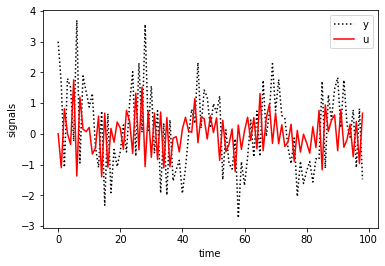

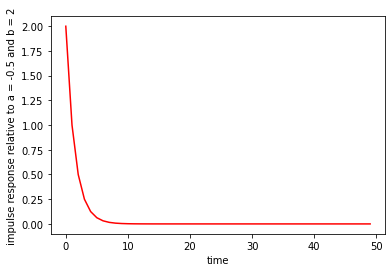

In [1510]:
y, u = simulate(a, b, K, lambda2, sigma2, y0, N, 0.3)

plt.figure()
plt.plot(y[:-1], 'k:', label = 'y')
plt.plot(u[:-1], 'r-', label = 'u')
plt.xlabel('time')
plt.ylabel('signals')
plt.legend()

plot_impulse_response(a, b)

### Task 3
In this task we want to implement a PEM-based approach to estimation of the system, assuming to know the correct model structure but not knowing about the existence of the feedback loop given by $K$.  

*Hint*: the system is an ARX, and e_k is Gaussian. What does this indicate about PEM? Given this, how can we simplify things?  

Implement the rest of the function `solve_pem`.

In [1511]:
def solve_pem(u, y):
    """Estimate a and b given u and y."""
    # TODO: Implement the features matrix and the normal equations
    # HINT: be careful with the indices of u and y

    # Compute the PEM estimate by directly solving the normal equations
    # normal equations = OLS since ARX + gaussian noise == OLS

    n = len(y)
    
    ## Why is this not working Sadge
    # phi = np.array((-y, u))
    # lhs = 1 / n * phi @ phi.T
    # rhs = 1 / n * y @ phi.T

    # a_hat, b_hat = np.linalg.solve(lhs, rhs)

    # a_hat = -theta[0]
    # b_hat = theta[1]
    
    a_hat = 0.1
    b_hat = 0.1

    theta = np.array((a_hat, b_hat)).reshape((2, 1))

    gamma = np.diag([0.1, 1])
    alpha = 1 # 0 = no normalization
    beta = 0.1

    epsilons = np.zeros((1,n))
    thetas = np.zeros((2, n))

    R = np.zeros((2, 2))
    Q = np.zeros((2, 1))

    for k in range(1, n):

        phi = np.array((-y[k - 1], u[k - 1])).reshape((2, 1))
        normalization = 1 + alpha * phi.T@phi
        innovation = y[k] - theta.T @ phi
        epsilon = innovation / normalization

        ## Gradient method with instantaneous cost
        # theta_dot = epsilon * gamma @ phi

        ## Gradient method with integral cost
        theta_dot = -gamma@(R@theta + Q)
        R_dot = -beta*R + phi@phi.T / normalization**2
        Q_dot = -beta*Q - y[k]*phi / normalization**2
    
        theta = theta + 0.5 * theta_dot
        R = R + 0.5 * R_dot
        Q = Q + 0.5 * Q_dot

        epsilons[0, k] = epsilon
        thetas[:, k] = theta.reshape((2,))

    a_hat = theta[0, 0]
    b_hat = theta[1, 0]

    return a_hat, b_hat, epsilons, thetas

,true,estimated
a,-0.5,-0.474839
b,2.0,2.038888


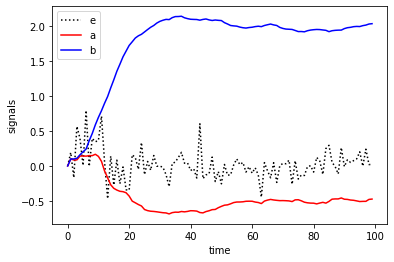

In [1512]:
# Compute the solution
a_hat, b_hat, e, t = solve_pem(u, y)

# Putting it in a df so it prints nicely

plt.figure()
plt.plot(e[0, :], 'k:', label = 'e')
plt.plot(t[0, :], 'r-', label = 'a')
plt.plot(t[1, :], 'b-', label = 'b')
plt.xlabel('time')
plt.ylabel('signals')
plt.legend()

pd.DataFrame({"a": [a, a_hat], "b": [b, b_hat]}, index=["true", "estimated"]).T


### Task 4.1
Show from a numerical perspective that for $\lambda^2 = 0.1$ (i.e., a constant variance on the process noise) the estimates are consistent.  

*Hint*: The best way to show this is with a Monte Carlo approach:  
1. For each N, compute the distribution of the estimates around the true parameters.  
2. Increase N and show that this distribution tends to converge to the true parameters.

In [1513]:
# Define the MC simulation
N_MC_runs = 100
min_order_for_N = 1
max_order_for_N = 4
num_of_N_orders = max_order_for_N - min_order_for_N + 1

# Noises and initial condition
lambda2 = 0.1 # on e
sigma2 = 0.1 # on r
y0 = 0

# Allocate storage
mse_vals = np.zeros(shape=(num_of_N_orders, N_MC_runs))
theta_hats = np.zeros(shape=(num_of_N_orders, N_MC_runs, 2))

# Generate numbers spaced evenly on a log-scale
sample_numbers = np.logspace(min_order_for_N, max_order_for_N, num_of_N_orders)

# Iterate over different sample numbers
for j, N in enumerate(sample_numbers):
    # MC cycles
    for m in range(N_MC_runs):
        # Simulate the system
        # TODO: Implement

        # Compute the solution
        # TODO: Implement

        # Save results
        theta_hats[j, m, 0] = a_hat
        theta_hats[j, m, 1] = b_hat
        
        # Store performance
        mse_vals[j, m] = np.linalg.norm([a - a_hat, b - b_hat]) ** 2

#### Plotting the error distributions for the varying sample numbers

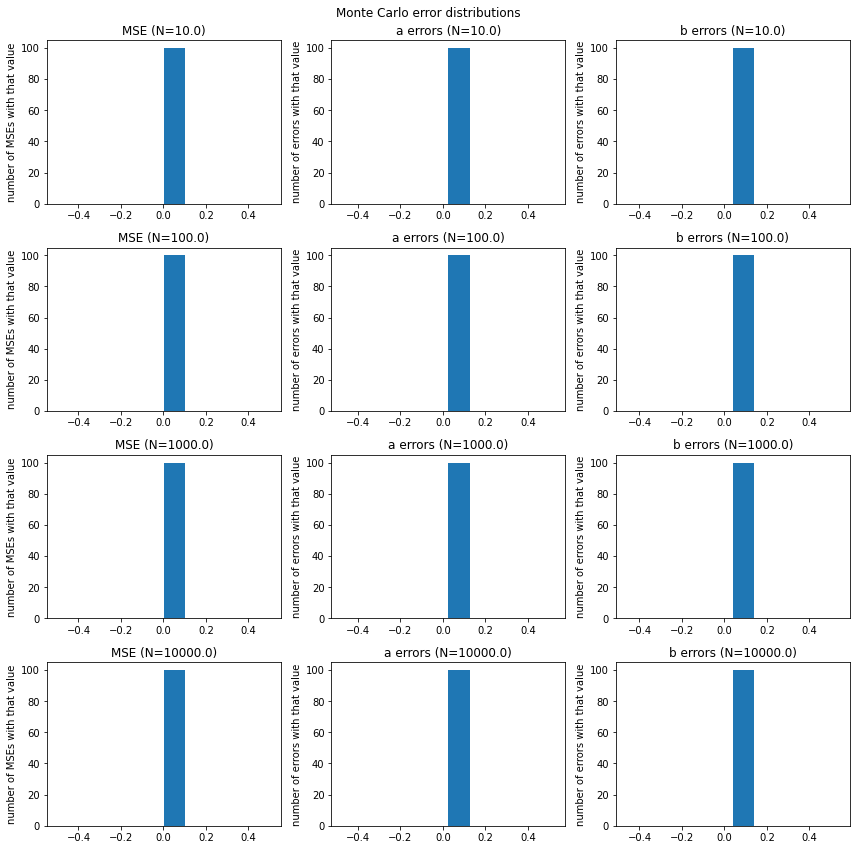

In [1514]:
def plot_error_distributions(sample_numbers, mse_values, theta_hats, value_name) -> None:
    fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(12, 12), sharex=False)

    # Iterate over different sample numbers
    for j, value in enumerate(sample_numbers):
        # Histogram of the MSEs relative to this number of samples
        axes[j, 0].hist(mse_values[j, :])
        axes[j, 0].set_title(f'MSE ({value_name}={value})')
        axes[j, 0].set_ylabel('number of MSEs with that value')

        # Histogram of errors along the a parameter
        axes[j, 1].hist(theta_hats[j, :, 0] - a)
        axes[j, 1].set_title(f'a errors ({value_name}={value})')
        axes[j, 1].set_ylabel('number of errors with that value')

        # Histogram of errors along the a parameter
        axes[j, 2].hist(theta_hats[j, :, 1] - b)
        axes[j, 2].set_title(f'b errors ({value_name}={value})')
        axes[j, 2].set_ylabel('number of errors with that value')

    plt.suptitle("Monte Carlo error distributions")
    plt.tight_layout()
    plt.show()
    
    
plot_error_distributions(sample_numbers, mse_vals, theta_hats, value_name="N")

### Task 4.2  
Comment on the above plots, relating to the description of 4.1.

### Task 5.1

Show that the variances of the estimates though will tend to infinity as $\sigma^2 \rightarrow 0$, i.e., the reference becomes a deterministic known signal.  

*Hint*: Again, the best way to show this is to do a Monte Carlo approach:
1. For each $\sigma^2$, compute the distribution of the estimates around the true parameters.
2. Diminish $\sigma^2$ and show that this distribution tends to diverge.

In [1515]:
# Define the MC simulation
N = 100
N_MC_runs = 100
min_order_sigma2 = -3
max_order_sigma2 = 1
num_of_sigma2_orders = max_order_sigma2 - min_order_sigma2 + 1

# noises and initial condition
lambda2 = 0.1 # on e
y0 = 0

# Allocate storage
mse_vals = np.zeros(shape=(num_of_N_orders, N_MC_runs))
theta_hats = np.zeros(shape=(num_of_N_orders, N_MC_runs, 2))

# Generate numbers spaced evenly on a log-scale
sample_numbers = np.logspace(min_order_sigma2, max_order_sigma2, num_of_N_orders)

# TODO: Implement Monte Carlo
# HINT: Don't reinvent the wheel


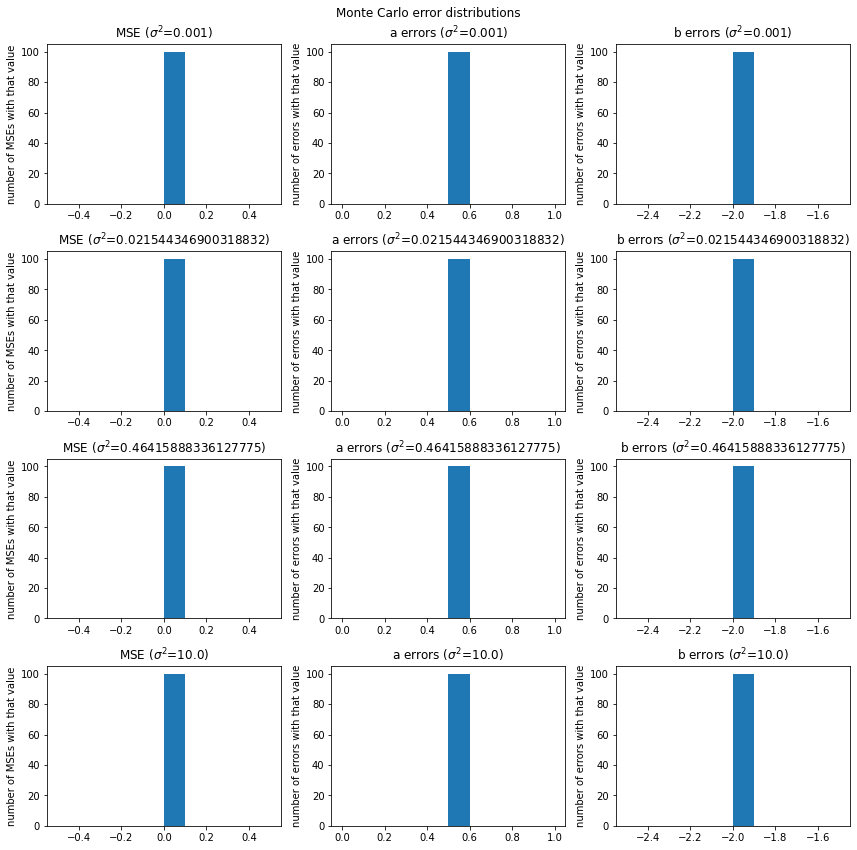

In [1516]:
plot_error_distributions(sample_numbers, mse_vals, theta_hats, value_name=r"$\sigma^2$")

### Task 5.2  
Comment on the above plots, relating to the description of 5.1.